In [65]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score
import re
import string
import gensim
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier
import tldextract
from urllib.parse import urlparse

In [66]:
df = pd.read_csv('phishing_site_urls.csv')
df.columns = [x.lower() for x in df.columns]
df['Y'] = df['label'].apply(lambda x: 0 if x == 'good' else 1)

In [67]:
def feature_creation(x):
    features = {}
    
    dom_ngram = {}
    subdom_ngram = {}

    dom = tldextract.extract(x).domain
    subdom = tldextract.extract(x).subdomain
    n  = 2
    for index in range(0, len(dom), n):
        dom_ngram[dom[index : index + n]] = 1
    features.update(dom_ngram)

    elements = [
    {"item": "domain", "data": tldextract.extract(x).domain},
    {"item": "subdomain", "data": tldextract.extract(x).subdomain},
    {"item": "suffix", "data": tldextract.extract(x).suffix},
    {"item": "path", "data": urlparse(x).path},
    {"item": "params", "data": urlparse(x).params},
    {"item": "query", "data": urlparse(x).query},
    {"item": "fragment", "data": urlparse(x).fragment}]
    
    for i in elements:
        features[f'len_{i["item"]}'] = len(i["data"])
        for sc in '!@#$%-_=~?+;':
            features[f'len_{sc}_in_{i["item"]}'] = i["data"].count(sc)
        if i["item"] in ['domain','path','subdomain']:
            features[f'len_digits_in_{i["item"]}'] = len(re.findall('[0-9]',x))
            features[f'len_alphas_in_{i["item"]}'] = len(re.findall('[a-z]',x.lower()))
    return features

In [68]:
y_elements = []
X_elements = []

for url, label in zip(df['url'], df['Y']):
    f = feature_creation(url)
    y_elements.append(label)
    X_elements.append(f)

In [69]:
len_domain = []
for i in X_elements:
    len_domain.append(i.get('len_domain'))
    
len_digits_in_domain =[]
for i in X_elements:
    len_digits_in_domain.append(i.get('len_digits_in_domain'))

len_alphas_in_path = []
for i in X_elements:
    len_alphas_in_path.append(i.get('len_alphas_in_path'))

len_digits_in_subdomain = []
for i in X_elements:
    len_digits_in_subdomain.append(i.get('len_digits_in_subdomain'))

len_alphas_in_subdomain =[]   
for i in X_elements:
    len_alphas_in_subdomain.append(i.get('len_alphas_in_subdomain'))

len_path = []
for i in X_elements:
    len_path.append(i.get('len_path'))
    
len_digits_in_path = []
for i in X_elements:
    len_digits_in_path.append(i.get('len_digits_in_path'))

len_alphas_in_path = []
for i in X_elements:
    len_alphas_in_path.append(i.get('len_alphas_in_path'))

len_suffix = []

In [88]:
pre_processor = DictVectorizer(sparse=True)
X = pre_processor.fit_transform(X_elements)
X = csr_matrix(X)
X = X.tocsr()
y = np.array(y_elements).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear SVM model without optimisation

In [71]:
%%time
from sklearn.svm import LinearSVC

svc_cls = LinearSVC(verbose = 3)

svc_cls.fit(X_train, y_train)
y_pred_svc = svc_cls.predict(X_test)

[LibLinear]CPU times: total: 4min 30s
Wall time: 4min 33s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [72]:
from sklearn import metrics
print('precision:', metrics.precision_score(y_test, y_pred_svc))
print('recall:', metrics.recall_score(y_test, y_pred_svc))
print('f1:', metrics.f1_score(y_test, y_pred_svc))
print('roc_auc:', metrics.roc_auc_score(y_test, y_pred_svc))

precision: 0.7896009673518742
recall: 0.46044871794871794
f1: 0.5816900838158481
roc_auc: 0.705894881409849



CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     91676
           1       0.46      0.79      0.58     18194

    accuracy                           0.81    109870
   macro avg       0.71      0.80      0.73    109870
weighted avg       0.87      0.81      0.83    109870


CONFUSION MATRIX


<AxesSubplot:>

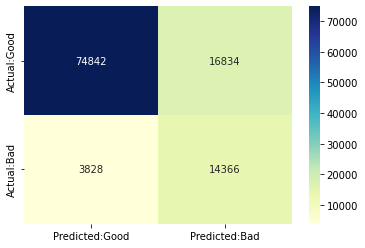

In [86]:
con_mat = pd.DataFrame(confusion_matrix(svc_cls.predict(X_test), y_test),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(svc_cls.predict(X_test), y_test))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### SGDClassifier using SVM (hinge loss) with hyperparameter optimisation:

In [74]:
from sklearn.linear_model import SGDClassifier

sgd_cls = SGDClassifier(verbose = 3)
parameters = {'loss': ['hinge', 'sqaured_hinge'],
             'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
             'n_jobs': [-1]}

gridsearch_cls = GridSearchCV(estimator=sgd_cls, param_grid=parameters, verbose = 3)
gridsearch_cls.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
-- Epoch 1
Norm: 261.65, NNZs: 2262, Bias: -9.590489, T: 351580, Avg. loss: 273.617665
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 175.97, NNZs: 2393, Bias: -10.190581, T: 703160, Avg. loss: 22.795555
Total training time: 0.33 seconds.
-- Epoch 3
Norm: 137.92, NNZs: 2408, Bias: -10.497745, T: 1054740, Avg. loss: 13.245100
Total training time: 0.47 seconds.
-- Epoch 4
Norm: 114.42, NNZs: 2413, Bias: -10.690652, T: 1406320, Avg. loss: 9.357086
Total training time: 0.62 seconds.
-- Epoch 5
Norm: 99.06, NNZs: 2423, Bias: -10.814412, T: 1757900, Avg. loss: 7.234245
Total training time: 0.77 seconds.
-- Epoch 6
Norm: 88.42, NNZs: 2428, Bias: -10.904031, T: 2109480, Avg. loss: 5.855206
Total training time: 0.93 seconds.
-- Epoch 7
Norm: 80.23, NNZs: 2434, Bias: -10.967376, T: 2461060, Avg. loss: 5.018272
Total training time: 1.07 seconds.
-- Epoch 8
Norm: 73.66, NNZs: 2439, Bias: -11.010991, T: 2812640, Avg. loss: 4.444745
T

Norm: 25.72, NNZs: 2512, Bias: -9.575318, T: 23907440, Avg. loss: 0.848162
Total training time: 11.49 seconds.
-- Epoch 69
Norm: 25.61, NNZs: 2512, Bias: -9.551865, T: 24259020, Avg. loss: 0.847340
Total training time: 11.65 seconds.
-- Epoch 70
Norm: 25.50, NNZs: 2512, Bias: -9.528144, T: 24610600, Avg. loss: 0.835140
Total training time: 11.80 seconds.
-- Epoch 71
Norm: 25.40, NNZs: 2512, Bias: -9.504624, T: 24962180, Avg. loss: 0.831660
Total training time: 11.95 seconds.
-- Epoch 72
Norm: 25.31, NNZs: 2512, Bias: -9.481275, T: 25313760, Avg. loss: 0.827752
Total training time: 12.11 seconds.
-- Epoch 73
Norm: 25.20, NNZs: 2512, Bias: -9.458257, T: 25665340, Avg. loss: 0.832860
Total training time: 12.26 seconds.
-- Epoch 74
Norm: 25.10, NNZs: 2512, Bias: -9.435572, T: 26016920, Avg. loss: 0.820544
Total training time: 12.48 seconds.
-- Epoch 75
Norm: 25.00, NNZs: 2513, Bias: -9.412953, T: 26368500, Avg. loss: 0.815605
Total training time: 12.69 seconds.
-- Epoch 76
Norm: 24.90, NNZ

Norm: 21.46, NNZs: 2521, Bias: -8.312594, T: 47814880, Avg. loss: 0.651736
Total training time: 23.60 seconds.
-- Epoch 137
Norm: 21.42, NNZs: 2521, Bias: -8.298221, T: 48166460, Avg. loss: 0.649448
Total training time: 23.76 seconds.
-- Epoch 138
Norm: 21.39, NNZs: 2521, Bias: -8.283855, T: 48518040, Avg. loss: 0.651048
Total training time: 23.92 seconds.
-- Epoch 139
Norm: 21.36, NNZs: 2521, Bias: -8.269619, T: 48869620, Avg. loss: 0.645756
Total training time: 24.09 seconds.
-- Epoch 140
Norm: 21.33, NNZs: 2521, Bias: -8.255482, T: 49221200, Avg. loss: 0.651982
Total training time: 24.26 seconds.
-- Epoch 141
Norm: 21.30, NNZs: 2521, Bias: -8.241277, T: 49572780, Avg. loss: 0.642877
Total training time: 24.42 seconds.
-- Epoch 142
Norm: 21.26, NNZs: 2521, Bias: -8.227242, T: 49924360, Avg. loss: 0.641560
Total training time: 24.58 seconds.
-- Epoch 143
Norm: 21.22, NNZs: 2521, Bias: -8.213171, T: 50275940, Avg. loss: 0.641809
Total training time: 24.75 seconds.
-- Epoch 144
Norm: 21

-- Epoch 1
Norm: 265.95, NNZs: 2121, Bias: -7.511761, T: 351581, Avg. loss: 290.265416
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 177.02, NNZs: 2314, Bias: -8.140703, T: 703162, Avg. loss: 22.438969
Total training time: 0.34 seconds.
-- Epoch 3
Norm: 138.15, NNZs: 2348, Bias: -8.461509, T: 1054743, Avg. loss: 13.145101
Total training time: 0.51 seconds.
-- Epoch 4
Norm: 114.87, NNZs: 2353, Bias: -8.673405, T: 1406324, Avg. loss: 9.195248
Total training time: 0.69 seconds.
-- Epoch 5
Norm: 99.32, NNZs: 2355, Bias: -8.819714, T: 1757905, Avg. loss: 7.131936
Total training time: 0.86 seconds.
-- Epoch 6
Norm: 88.44, NNZs: 2364, Bias: -8.930075, T: 2109486, Avg. loss: 5.985384
Total training time: 1.03 seconds.
-- Epoch 7
Norm: 80.09, NNZs: 2375, Bias: -9.008869, T: 2461067, Avg. loss: 5.064989
Total training time: 1.20 seconds.
-- Epoch 8
Norm: 73.67, NNZs: 2390, Bias: -9.061322, T: 2812648, Avg. loss: 4.323872
Total training time: 1.35 seconds.
-- Epoch 9
Norm: 68.27, NNZs: 2391

Norm: 24.48, NNZs: 2456, Bias: -8.051823, T: 24610670, Avg. loss: 0.812739
Total training time: 10.79 seconds.
-- Epoch 71
Norm: 24.38, NNZs: 2456, Bias: -8.032051, T: 24962251, Avg. loss: 0.818218
Total training time: 10.94 seconds.
-- Epoch 72
Norm: 24.27, NNZs: 2459, Bias: -8.012708, T: 25313832, Avg. loss: 0.801419
Total training time: 11.10 seconds.
-- Epoch 73
Norm: 24.17, NNZs: 2459, Bias: -7.993251, T: 25665413, Avg. loss: 0.793237
Total training time: 11.27 seconds.
-- Epoch 74
Norm: 24.07, NNZs: 2459, Bias: -7.974514, T: 26016994, Avg. loss: 0.788478
Total training time: 11.43 seconds.
-- Epoch 75
Norm: 23.97, NNZs: 2459, Bias: -7.955520, T: 26368575, Avg. loss: 0.783992
Total training time: 11.59 seconds.
-- Epoch 76
Norm: 23.85, NNZs: 2459, Bias: -7.936773, T: 26720156, Avg. loss: 0.773471
Total training time: 11.76 seconds.
-- Epoch 77
Norm: 23.75, NNZs: 2459, Bias: -7.918160, T: 27071737, Avg. loss: 0.778147
Total training time: 11.92 seconds.
-- Epoch 78
Norm: 23.66, NNZ

Norm: 20.30, NNZs: 2467, Bias: -6.994801, T: 48518178, Avg. loss: 0.622567
Total training time: 21.32 seconds.
-- Epoch 139
Norm: 20.26, NNZs: 2467, Bias: -6.982502, T: 48869759, Avg. loss: 0.618595
Total training time: 21.48 seconds.
-- Epoch 140
Norm: 20.22, NNZs: 2467, Bias: -6.970267, T: 49221340, Avg. loss: 0.616590
Total training time: 21.65 seconds.
-- Epoch 141
Norm: 20.19, NNZs: 2467, Bias: -6.958242, T: 49572921, Avg. loss: 0.616691
Total training time: 21.80 seconds.
-- Epoch 142
Norm: 20.16, NNZs: 2467, Bias: -6.946174, T: 49924502, Avg. loss: 0.614633
Total training time: 21.96 seconds.
-- Epoch 143
Norm: 20.12, NNZs: 2467, Bias: -6.934221, T: 50276083, Avg. loss: 0.614033
Total training time: 22.11 seconds.
-- Epoch 144
Norm: 20.09, NNZs: 2467, Bias: -6.922247, T: 50627664, Avg. loss: 0.616973
Total training time: 22.26 seconds.
-- Epoch 145
Norm: 20.05, NNZs: 2467, Bias: -6.910502, T: 50979245, Avg. loss: 0.609469
Total training time: 22.43 seconds.
-- Epoch 146
Norm: 20

Norm: 18.57, NNZs: 2470, Bias: -6.295833, T: 72425686, Avg. loss: 0.553064
Total training time: 31.79 seconds.
-- Epoch 207
Norm: 18.55, NNZs: 2470, Bias: -6.287306, T: 72777267, Avg. loss: 0.552113
Total training time: 31.93 seconds.
-- Epoch 208
Norm: 18.53, NNZs: 2470, Bias: -6.278751, T: 73128848, Avg. loss: 0.555876
Total training time: 32.08 seconds.
-- Epoch 209
Norm: 18.51, NNZs: 2470, Bias: -6.270285, T: 73480429, Avg. loss: 0.550466
Total training time: 32.23 seconds.
-- Epoch 210
Norm: 18.50, NNZs: 2470, Bias: -6.261763, T: 73832010, Avg. loss: 0.552405
Total training time: 32.37 seconds.
-- Epoch 211
Norm: 18.48, NNZs: 2470, Bias: -6.253360, T: 74183591, Avg. loss: 0.550333
Total training time: 32.51 seconds.
-- Epoch 212
Norm: 18.46, NNZs: 2470, Bias: -6.244967, T: 74535172, Avg. loss: 0.553070
Total training time: 32.65 seconds.
-- Epoch 213
Norm: 18.45, NNZs: 2470, Bias: -6.236631, T: 74886753, Avg. loss: 0.548738
Total training time: 32.80 seconds.
-- Epoch 214
Norm: 18

Norm: 28.83, NNZs: 2508, Bias: -9.010256, T: 16172726, Avg. loss: 1.004229
Total training time: 7.01 seconds.
-- Epoch 47
Norm: 28.58, NNZs: 2508, Bias: -8.985757, T: 16524307, Avg. loss: 0.997611
Total training time: 7.17 seconds.
-- Epoch 48
Norm: 28.36, NNZs: 2508, Bias: -8.961731, T: 16875888, Avg. loss: 0.992163
Total training time: 7.31 seconds.
-- Epoch 49
Norm: 28.16, NNZs: 2510, Bias: -8.937416, T: 17227469, Avg. loss: 0.977438
Total training time: 7.45 seconds.
-- Epoch 50
Norm: 27.94, NNZs: 2510, Bias: -8.913378, T: 17579050, Avg. loss: 0.961358
Total training time: 7.61 seconds.
-- Epoch 51
Norm: 27.76, NNZs: 2511, Bias: -8.890104, T: 17930631, Avg. loss: 0.968574
Total training time: 7.77 seconds.
-- Epoch 52
Norm: 27.54, NNZs: 2511, Bias: -8.866802, T: 18282212, Avg. loss: 0.938510
Total training time: 7.94 seconds.
-- Epoch 53
Norm: 27.36, NNZs: 2511, Bias: -8.843106, T: 18633793, Avg. loss: 0.936304
Total training time: 8.11 seconds.
-- Epoch 54
Norm: 27.18, NNZs: 2511,

Norm: 21.65, NNZs: 2528, Bias: -7.692579, T: 40080234, Avg. loss: 0.665410
Total training time: 17.55 seconds.
-- Epoch 115
Norm: 21.60, NNZs: 2528, Bias: -7.677687, T: 40431815, Avg. loss: 0.667073
Total training time: 17.70 seconds.
-- Epoch 116
Norm: 21.55, NNZs: 2528, Bias: -7.662900, T: 40783396, Avg. loss: 0.660924
Total training time: 17.85 seconds.
-- Epoch 117
Norm: 21.51, NNZs: 2528, Bias: -7.648266, T: 41134977, Avg. loss: 0.658871
Total training time: 18.00 seconds.
-- Epoch 118
Norm: 21.46, NNZs: 2528, Bias: -7.633541, T: 41486558, Avg. loss: 0.655805
Total training time: 18.15 seconds.
-- Epoch 119
Norm: 21.41, NNZs: 2528, Bias: -7.619033, T: 41838139, Avg. loss: 0.654490
Total training time: 18.33 seconds.
-- Epoch 120
Norm: 21.36, NNZs: 2528, Bias: -7.604452, T: 42189720, Avg. loss: 0.654915
Total training time: 18.51 seconds.
-- Epoch 121
Norm: 21.31, NNZs: 2528, Bias: -7.589948, T: 42541301, Avg. loss: 0.652810
Total training time: 18.68 seconds.
-- Epoch 122
Norm: 21

Norm: 19.41, NNZs: 2531, Bias: -6.858082, T: 63987742, Avg. loss: 0.576221
Total training time: 27.99 seconds.
-- Epoch 183
Norm: 19.38, NNZs: 2531, Bias: -6.848064, T: 64339323, Avg. loss: 0.576961
Total training time: 28.14 seconds.
-- Epoch 184
Norm: 19.36, NNZs: 2531, Bias: -6.838026, T: 64690904, Avg. loss: 0.574690
Total training time: 28.29 seconds.
-- Epoch 185
Norm: 19.33, NNZs: 2531, Bias: -6.828075, T: 65042485, Avg. loss: 0.574250
Total training time: 28.43 seconds.
-- Epoch 186
Norm: 19.31, NNZs: 2531, Bias: -6.818073, T: 65394066, Avg. loss: 0.573952
Total training time: 28.59 seconds.
-- Epoch 187
Norm: 19.29, NNZs: 2531, Bias: -6.808119, T: 65745647, Avg. loss: 0.572851
Total training time: 28.75 seconds.
-- Epoch 188
Norm: 19.27, NNZs: 2531, Bias: -6.798213, T: 66097228, Avg. loss: 0.571039
Total training time: 28.90 seconds.
-- Epoch 189
Norm: 19.25, NNZs: 2532, Bias: -6.788406, T: 66448809, Avg. loss: 0.571041
Total training time: 29.04 seconds.
-- Epoch 190
Norm: 19

Norm: 52.03, NNZs: 2322, Bias: -10.561924, T: 4922134, Avg. loss: 2.483796
Total training time: 2.13 seconds.
-- Epoch 15
Norm: 50.00, NNZs: 2325, Bias: -10.551317, T: 5273715, Avg. loss: 2.325507
Total training time: 2.30 seconds.
-- Epoch 16
Norm: 48.20, NNZs: 2325, Bias: -10.537418, T: 5625296, Avg. loss: 2.196622
Total training time: 2.47 seconds.
-- Epoch 17
Norm: 46.56, NNZs: 2329, Bias: -10.522811, T: 5976877, Avg. loss: 2.129014
Total training time: 2.63 seconds.
-- Epoch 18
Norm: 45.17, NNZs: 2329, Bias: -10.503738, T: 6328458, Avg. loss: 2.050902
Total training time: 2.79 seconds.
-- Epoch 19
Norm: 43.93, NNZs: 2329, Bias: -10.482804, T: 6680039, Avg. loss: 1.913631
Total training time: 2.94 seconds.
-- Epoch 20
Norm: 42.69, NNZs: 2334, Bias: -10.460683, T: 7031620, Avg. loss: 1.824537
Total training time: 3.08 seconds.
-- Epoch 21
Norm: 41.48, NNZs: 2336, Bias: -10.436273, T: 7383201, Avg. loss: 1.753512
Total training time: 3.23 seconds.
-- Epoch 22
Norm: 40.54, NNZs: 2336,

Norm: 24.02, NNZs: 2364, Bias: -8.888378, T: 28829642, Avg. loss: 0.769703
Total training time: 12.42 seconds.
-- Epoch 83
Norm: 23.95, NNZs: 2364, Bias: -8.867677, T: 29181223, Avg. loss: 0.766169
Total training time: 12.57 seconds.
-- Epoch 84
Norm: 23.88, NNZs: 2364, Bias: -8.847424, T: 29532804, Avg. loss: 0.767519
Total training time: 12.72 seconds.
-- Epoch 85
Norm: 23.80, NNZs: 2364, Bias: -8.827409, T: 29884385, Avg. loss: 0.762751
Total training time: 12.87 seconds.
-- Epoch 86
Norm: 23.73, NNZs: 2364, Bias: -8.807530, T: 30235966, Avg. loss: 0.754923
Total training time: 13.02 seconds.
-- Epoch 87
Norm: 23.66, NNZs: 2364, Bias: -8.787700, T: 30587547, Avg. loss: 0.752339
Total training time: 13.16 seconds.
-- Epoch 88
Norm: 23.57, NNZs: 2364, Bias: -8.767976, T: 30939128, Avg. loss: 0.746935
Total training time: 13.31 seconds.
-- Epoch 89
Norm: 23.49, NNZs: 2368, Bias: -8.748669, T: 31290709, Avg. loss: 0.744977
Total training time: 13.46 seconds.
-- Epoch 90
Norm: 23.43, NNZ

Norm: 20.67, NNZs: 2372, Bias: -7.787510, T: 52737150, Avg. loss: 0.622979
Total training time: 23.34 seconds.
-- Epoch 151
Norm: 20.63, NNZs: 2372, Bias: -7.774651, T: 53088731, Avg. loss: 0.620242
Total training time: 23.49 seconds.
-- Epoch 152
Norm: 20.61, NNZs: 2375, Bias: -7.761731, T: 53440312, Avg. loss: 0.620183
Total training time: 23.63 seconds.
-- Epoch 153
Norm: 20.58, NNZs: 2375, Bias: -7.749010, T: 53791893, Avg. loss: 0.618170
Total training time: 23.79 seconds.
-- Epoch 154
Norm: 20.55, NNZs: 2375, Bias: -7.736416, T: 54143474, Avg. loss: 0.618554
Total training time: 23.93 seconds.
-- Epoch 155
Norm: 20.52, NNZs: 2375, Bias: -7.723831, T: 54495055, Avg. loss: 0.615085
Total training time: 24.08 seconds.
-- Epoch 156
Norm: 20.49, NNZs: 2375, Bias: -7.711474, T: 54846636, Avg. loss: 0.616556
Total training time: 24.23 seconds.
-- Epoch 157
Norm: 20.47, NNZs: 2375, Bias: -7.699014, T: 55198217, Avg. loss: 0.615137
Total training time: 24.37 seconds.
-- Epoch 158
Norm: 20

-- Epoch 1
Norm: 262.83, NNZs: 2196, Bias: -9.849641, T: 351581, Avg. loss: 288.346264
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 176.62, NNZs: 2354, Bias: -10.458426, T: 703162, Avg. loss: 22.667218
Total training time: 0.32 seconds.
-- Epoch 3
Norm: 137.84, NNZs: 2403, Bias: -10.776647, T: 1054743, Avg. loss: 13.122735
Total training time: 0.50 seconds.
-- Epoch 4
Norm: 114.04, NNZs: 2410, Bias: -10.966089, T: 1406324, Avg. loss: 9.105874
Total training time: 0.67 seconds.
-- Epoch 5
Norm: 99.05, NNZs: 2420, Bias: -11.095884, T: 1757905, Avg. loss: 7.050399
Total training time: 0.85 seconds.
-- Epoch 6
Norm: 88.07, NNZs: 2425, Bias: -11.187641, T: 2109486, Avg. loss: 5.870397
Total training time: 1.01 seconds.
-- Epoch 7
Norm: 79.75, NNZs: 2425, Bias: -11.245119, T: 2461067, Avg. loss: 4.972116
Total training time: 1.16 seconds.
-- Epoch 8
Norm: 73.43, NNZs: 2431, Bias: -11.287696, T: 2812648, Avg. loss: 4.271788
Total training time: 1.35 seconds.
-- Epoch 9
Norm: 68.40, NNZ

Norm: 25.81, NNZs: 2477, Bias: -9.789268, T: 23907508, Avg. loss: 0.845930
Total training time: 10.71 seconds.
-- Epoch 69
Norm: 25.70, NNZs: 2478, Bias: -9.765027, T: 24259089, Avg. loss: 0.835961
Total training time: 10.86 seconds.
-- Epoch 70
Norm: 25.58, NNZs: 2478, Bias: -9.741033, T: 24610670, Avg. loss: 0.844432
Total training time: 11.01 seconds.
-- Epoch 71
Norm: 25.48, NNZs: 2478, Bias: -9.717303, T: 24962251, Avg. loss: 0.827931
Total training time: 11.15 seconds.
-- Epoch 72
Norm: 25.36, NNZs: 2478, Bias: -9.693783, T: 25313832, Avg. loss: 0.820144
Total training time: 11.30 seconds.
-- Epoch 73
Norm: 25.25, NNZs: 2479, Bias: -9.670257, T: 25665413, Avg. loss: 0.829075
Total training time: 11.45 seconds.
-- Epoch 74
Norm: 25.16, NNZs: 2479, Bias: -9.646700, T: 26016994, Avg. loss: 0.813269
Total training time: 11.59 seconds.
-- Epoch 75
Norm: 25.06, NNZs: 2479, Bias: -9.623778, T: 26368575, Avg. loss: 0.805556
Total training time: 11.74 seconds.
-- Epoch 76
Norm: 24.96, NNZ

Norm: 21.54, NNZs: 2490, Bias: -8.502657, T: 47815016, Avg. loss: 0.648813
Total training time: 20.88 seconds.
-- Epoch 137
Norm: 21.50, NNZs: 2490, Bias: -8.487935, T: 48166597, Avg. loss: 0.649998
Total training time: 21.02 seconds.
-- Epoch 138
Norm: 21.47, NNZs: 2490, Bias: -8.473143, T: 48518178, Avg. loss: 0.647127
Total training time: 21.17 seconds.
-- Epoch 139
Norm: 21.44, NNZs: 2490, Bias: -8.458534, T: 48869759, Avg. loss: 0.643625
Total training time: 21.33 seconds.
-- Epoch 140
Norm: 21.40, NNZs: 2490, Bias: -8.444051, T: 49221340, Avg. loss: 0.644823
Total training time: 21.49 seconds.
-- Epoch 141
Norm: 21.36, NNZs: 2490, Bias: -8.429629, T: 49572921, Avg. loss: 0.643460
Total training time: 21.65 seconds.
-- Epoch 142
Norm: 21.33, NNZs: 2490, Bias: -8.415328, T: 49924502, Avg. loss: 0.645508
Total training time: 21.80 seconds.
-- Epoch 143
Norm: 21.30, NNZs: 2490, Bias: -8.401188, T: 50276083, Avg. loss: 0.641348
Total training time: 21.94 seconds.
-- Epoch 144
Norm: 21

Norm: 19.79, NNZs: 2494, Bias: -7.667207, T: 71722524, Avg. loss: 0.579278
Total training time: 31.32 seconds.
-- Epoch 205
Norm: 19.76, NNZs: 2494, Bias: -7.656901, T: 72074105, Avg. loss: 0.578104
Total training time: 31.48 seconds.
-- Epoch 206
Norm: 19.74, NNZs: 2497, Bias: -7.646654, T: 72425686, Avg. loss: 0.577930
Total training time: 31.66 seconds.
-- Epoch 207
Norm: 19.72, NNZs: 2497, Bias: -7.636492, T: 72777267, Avg. loss: 0.577854
Total training time: 31.83 seconds.
-- Epoch 208
Norm: 19.71, NNZs: 2497, Bias: -7.626411, T: 73128848, Avg. loss: 0.577172
Total training time: 31.99 seconds.
-- Epoch 209
Norm: 19.68, NNZs: 2497, Bias: -7.616345, T: 73480429, Avg. loss: 0.577378
Total training time: 32.15 seconds.
-- Epoch 210
Norm: 19.67, NNZs: 2497, Bias: -7.606399, T: 73832010, Avg. loss: 0.578967
Total training time: 32.29 seconds.
Convergence after 210 epochs took 32.29 seconds
[CV 5/5] END alpha=0.0001, loss=hinge, n_jobs=-1;, score=0.819 total time=  32.4s
[CV 1/5] END al

Norm: 6.31, NNZs: 2508, Bias: -1.435024, T: 20391640, Avg. loss: 0.456782
Total training time: 9.27 seconds.
-- Epoch 59
Norm: 6.30, NNZs: 2508, Bias: -1.435795, T: 20743220, Avg. loss: 0.456575
Total training time: 9.44 seconds.
-- Epoch 60
Norm: 6.29, NNZs: 2508, Bias: -1.436510, T: 21094800, Avg. loss: 0.456254
Total training time: 9.59 seconds.
-- Epoch 61
Norm: 6.28, NNZs: 2508, Bias: -1.437289, T: 21446380, Avg. loss: 0.455689
Total training time: 9.76 seconds.
-- Epoch 62
Norm: 6.27, NNZs: 2508, Bias: -1.437934, T: 21797960, Avg. loss: 0.454930
Total training time: 9.92 seconds.
-- Epoch 63
Norm: 6.26, NNZs: 2508, Bias: -1.438642, T: 22149540, Avg. loss: 0.453056
Total training time: 10.10 seconds.
-- Epoch 64
Norm: 6.25, NNZs: 2508, Bias: -1.439321, T: 22501120, Avg. loss: 0.453139
Total training time: 10.28 seconds.
-- Epoch 65
Norm: 6.24, NNZs: 2508, Bias: -1.440015, T: 22852700, Avg. loss: 0.452862
Total training time: 10.44 seconds.
-- Epoch 66
Norm: 6.23, NNZs: 2508, Bias:

Norm: 6.45, NNZs: 2440, Bias: -1.701349, T: 17579050, Avg. loss: 0.463496
Total training time: 7.66 seconds.
-- Epoch 51
Norm: 6.43, NNZs: 2440, Bias: -1.701711, T: 17930631, Avg. loss: 0.461624
Total training time: 7.82 seconds.
-- Epoch 52
Norm: 6.41, NNZs: 2442, Bias: -1.702080, T: 18282212, Avg. loss: 0.460806
Total training time: 7.97 seconds.
-- Epoch 53
Norm: 6.40, NNZs: 2442, Bias: -1.702433, T: 18633793, Avg. loss: 0.460293
Total training time: 8.12 seconds.
-- Epoch 54
Norm: 6.39, NNZs: 2442, Bias: -1.702798, T: 18985374, Avg. loss: 0.459450
Total training time: 8.27 seconds.
-- Epoch 55
Norm: 6.37, NNZs: 2442, Bias: -1.703158, T: 19336955, Avg. loss: 0.458277
Total training time: 8.42 seconds.
-- Epoch 56
Norm: 6.36, NNZs: 2442, Bias: -1.703477, T: 19688536, Avg. loss: 0.458038
Total training time: 8.57 seconds.
-- Epoch 57
Norm: 6.35, NNZs: 2442, Bias: -1.703783, T: 20040117, Avg. loss: 0.456978
Total training time: 8.72 seconds.
-- Epoch 58
Norm: 6.34, NNZs: 2446, Bias: -1

Norm: 6.38, NNZs: 2480, Bias: -1.399761, T: 18282212, Avg. loss: 0.461661
Total training time: 8.19 seconds.
-- Epoch 53
Norm: 6.37, NNZs: 2480, Bias: -1.400629, T: 18633793, Avg. loss: 0.460735
Total training time: 8.35 seconds.
-- Epoch 54
Norm: 6.36, NNZs: 2481, Bias: -1.401529, T: 18985374, Avg. loss: 0.459841
Total training time: 8.51 seconds.
-- Epoch 55
Norm: 6.34, NNZs: 2481, Bias: -1.402369, T: 19336955, Avg. loss: 0.459491
Total training time: 8.67 seconds.
-- Epoch 56
Norm: 6.33, NNZs: 2481, Bias: -1.403186, T: 19688536, Avg. loss: 0.458051
Total training time: 8.83 seconds.
-- Epoch 57
Norm: 6.32, NNZs: 2481, Bias: -1.404017, T: 20040117, Avg. loss: 0.457164
Total training time: 8.99 seconds.
-- Epoch 58
Norm: 6.31, NNZs: 2481, Bias: -1.404857, T: 20391698, Avg. loss: 0.455981
Total training time: 9.14 seconds.
-- Epoch 59
Norm: 6.30, NNZs: 2481, Bias: -1.405666, T: 20743279, Avg. loss: 0.455897
Total training time: 9.30 seconds.
-- Epoch 60
Norm: 6.28, NNZs: 2481, Bias: -1

Norm: 6.49, NNZs: 2361, Bias: -1.343942, T: 15469564, Avg. loss: 0.472191
Total training time: 6.84 seconds.
-- Epoch 45
Norm: 6.47, NNZs: 2361, Bias: -1.345066, T: 15821145, Avg. loss: 0.470695
Total training time: 6.99 seconds.
-- Epoch 46
Norm: 6.46, NNZs: 2361, Bias: -1.346210, T: 16172726, Avg. loss: 0.468544
Total training time: 7.15 seconds.
-- Epoch 47
Norm: 6.44, NNZs: 2361, Bias: -1.347370, T: 16524307, Avg. loss: 0.468203
Total training time: 7.30 seconds.
-- Epoch 48
Norm: 6.42, NNZs: 2361, Bias: -1.348447, T: 16875888, Avg. loss: 0.466473
Total training time: 7.46 seconds.
-- Epoch 49
Norm: 6.41, NNZs: 2361, Bias: -1.349536, T: 17227469, Avg. loss: 0.465652
Total training time: 7.61 seconds.
-- Epoch 50
Norm: 6.39, NNZs: 2361, Bias: -1.350544, T: 17579050, Avg. loss: 0.464644
Total training time: 7.77 seconds.
-- Epoch 51
Norm: 6.38, NNZs: 2361, Bias: -1.351598, T: 17930631, Avg. loss: 0.463236
Total training time: 7.92 seconds.
-- Epoch 52
Norm: 6.36, NNZs: 2361, Bias: -1

Norm: 6.42, NNZs: 2458, Bias: -1.156864, T: 16875888, Avg. loss: 0.466843
Total training time: 7.37 seconds.
-- Epoch 49
Norm: 6.40, NNZs: 2458, Bias: -1.158256, T: 17227469, Avg. loss: 0.465943
Total training time: 7.52 seconds.
-- Epoch 50
Norm: 6.39, NNZs: 2458, Bias: -1.159678, T: 17579050, Avg. loss: 0.465678
Total training time: 7.68 seconds.
-- Epoch 51
Norm: 6.37, NNZs: 2458, Bias: -1.161011, T: 17930631, Avg. loss: 0.464266
Total training time: 7.84 seconds.
-- Epoch 52
Norm: 6.36, NNZs: 2458, Bias: -1.162321, T: 18282212, Avg. loss: 0.462712
Total training time: 7.99 seconds.
-- Epoch 53
Norm: 6.34, NNZs: 2458, Bias: -1.163653, T: 18633793, Avg. loss: 0.462852
Total training time: 8.15 seconds.
-- Epoch 54
Norm: 6.33, NNZs: 2458, Bias: -1.164932, T: 18985374, Avg. loss: 0.461080
Total training time: 8.30 seconds.
-- Epoch 55
Norm: 6.32, NNZs: 2458, Bias: -1.166136, T: 19336955, Avg. loss: 0.459776
Total training time: 8.46 seconds.
-- Epoch 56
Norm: 6.31, NNZs: 2458, Bias: -1

Norm: 2.87, NNZs: 2401, Bias: -0.168723, T: 703162, Avg. loss: 0.677222
Total training time: 0.33 seconds.
-- Epoch 3
Norm: 2.60, NNZs: 2417, Bias: -0.173700, T: 1054743, Avg. loss: 0.582515
Total training time: 0.49 seconds.
-- Epoch 4
Norm: 2.45, NNZs: 2432, Bias: -0.177402, T: 1406324, Avg. loss: 0.546238
Total training time: 0.64 seconds.
-- Epoch 5
Norm: 2.36, NNZs: 2439, Bias: -0.180383, T: 1757905, Avg. loss: 0.526614
Total training time: 0.79 seconds.
-- Epoch 6
Norm: 2.29, NNZs: 2439, Bias: -0.182861, T: 2109486, Avg. loss: 0.514802
Total training time: 0.95 seconds.
-- Epoch 7
Norm: 2.23, NNZs: 2439, Bias: -0.184878, T: 2461067, Avg. loss: 0.505943
Total training time: 1.11 seconds.
-- Epoch 8
Norm: 2.19, NNZs: 2439, Bias: -0.186709, T: 2812648, Avg. loss: 0.500447
Total training time: 1.26 seconds.
-- Epoch 9
Norm: 2.16, NNZs: 2439, Bias: -0.188282, T: 3164229, Avg. loss: 0.495605
Total training time: 1.42 seconds.
-- Epoch 10
Norm: 2.13, NNZs: 2440, Bias: -0.189709, T: 3515

Norm: 2.01, NNZs: 2432, Bias: -0.251056, T: 6328458, Avg. loss: 0.478239
Total training time: 2.85 seconds.
-- Epoch 19
Norm: 2.00, NNZs: 2432, Bias: -0.251772, T: 6680039, Avg. loss: 0.477208
Total training time: 3.01 seconds.
-- Epoch 20
Norm: 1.99, NNZs: 2432, Bias: -0.252467, T: 7031620, Avg. loss: 0.476431
Total training time: 3.17 seconds.
-- Epoch 21
Norm: 1.98, NNZs: 2433, Bias: -0.253100, T: 7383201, Avg. loss: 0.475786
Total training time: 3.34 seconds.
-- Epoch 22
Norm: 1.98, NNZs: 2433, Bias: -0.253720, T: 7734782, Avg. loss: 0.475123
Total training time: 3.50 seconds.
-- Epoch 23
Norm: 1.97, NNZs: 2433, Bias: -0.254301, T: 8086363, Avg. loss: 0.474642
Total training time: 3.66 seconds.
-- Epoch 24
Norm: 1.96, NNZs: 2433, Bias: -0.254872, T: 8437944, Avg. loss: 0.474244
Total training time: 3.82 seconds.
Convergence after 24 epochs took 3.83 seconds
[CV 5/5] END .alpha=0.01, loss=hinge, n_jobs=-1;, score=0.783 total time=   4.0s
[CV 1/5] END alpha=0.01, loss=sqaured_hinge, 

Norm: 0.65, NNZs: 2420, Bias: -0.017337, T: 3515810, Avg. loss: 0.507205
Total training time: 1.81 seconds.
-- Epoch 11
Norm: 0.64, NNZs: 2420, Bias: -0.017503, T: 3867391, Avg. loss: 0.506875
Total training time: 2.00 seconds.
Convergence after 11 epochs took 2.00 seconds
[CV 5/5] END ..alpha=0.1, loss=hinge, n_jobs=-1;, score=0.771 total time=   2.2s
[CV 1/5] END alpha=0.1, loss=sqaured_hinge, n_jobs=-1;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.1, loss=sqaured_hinge, n_jobs=-1;, score=nan total time=   0.1s
[CV 3/5] END alpha=0.1, loss=sqaured_hinge, n_jobs=-1;, score=nan total time=   0.1s
[CV 4/5] END alpha=0.1, loss=sqaured_hinge, n_jobs=-1;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.1, loss=sqaured_hinge, n_jobs=-1;, score=nan total time=   0.0s
-- Epoch 1
Norm: 0.26, NNZs: 1942, Bias: -0.008975, T: 351580, Avg. loss: 0.626876
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 0.26, NNZs: 1974, Bias: -0.009567, T: 703160, Avg. loss: 0.555974
Total training time

Norm: 0.06, NNZs: 1883, Bias: 0.003444, T: 2109486, Avg. loss: 0.628298
Total training time: 1.02 seconds.
-- Epoch 7
Norm: 0.06, NNZs: 1883, Bias: 0.003426, T: 2461067, Avg. loss: 0.628223
Total training time: 1.19 seconds.
Convergence after 7 epochs took 1.19 seconds
[CV 2/5] END ...alpha=10, loss=hinge, n_jobs=-1;, score=0.739 total time=   1.3s
-- Epoch 1
Norm: 0.06, NNZs: 1831, Bias: 0.004762, T: 351581, Avg. loss: 0.633522
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 1831, Bias: 0.004678, T: 703162, Avg. loss: 0.628027
Total training time: 0.33 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 1852, Bias: 0.004629, T: 1054743, Avg. loss: 0.627913
Total training time: 0.51 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 1852, Bias: 0.004594, T: 1406324, Avg. loss: 0.627886
Total training time: 0.68 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 1852, Bias: 0.004567, T: 1757905, Avg. loss: 0.627818
Total training time: 0.85 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 1852, Bias: 0.004545, T: 2109486

C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 890, in fit
    return self._fit(
  File "C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sk

Norm: 231.66, NNZs: 2318, Bias: -8.628563, T: 439476, Avg. loss: 226.340885
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 153.40, NNZs: 2557, Bias: -9.219358, T: 878952, Avg. loss: 18.171982
Total training time: 0.45 seconds.
-- Epoch 3
Norm: 118.48, NNZs: 2575, Bias: -9.523153, T: 1318428, Avg. loss: 10.233824
Total training time: 0.63 seconds.
-- Epoch 4
Norm: 98.83, NNZs: 2581, Bias: -9.713088, T: 1757904, Avg. loss: 7.493183
Total training time: 0.83 seconds.
-- Epoch 5
Norm: 85.42, NNZs: 2588, Bias: -9.835663, T: 2197380, Avg. loss: 5.777154
Total training time: 1.02 seconds.
-- Epoch 6
Norm: 75.91, NNZs: 2608, Bias: -9.911560, T: 2636856, Avg. loss: 4.644570
Total training time: 1.21 seconds.
-- Epoch 7
Norm: 68.91, NNZs: 2614, Bias: -9.964780, T: 3076332, Avg. loss: 3.959928
Total training time: 1.40 seconds.
-- Epoch 8
Norm: 63.44, NNZs: 2636, Bias: -9.998169, T: 3515808, Avg. loss: 3.468611
Total training time: 1.60 seconds.
-- Epoch 9
Norm: 59.08, NNZs: 2640, Bias: -10.

Norm: 23.38, NNZs: 2688, Bias: -8.397479, T: 30323844, Avg. loss: 0.746620
Total training time: 13.35 seconds.
-- Epoch 70
Norm: 23.29, NNZs: 2688, Bias: -8.373938, T: 30763320, Avg. loss: 0.741525
Total training time: 13.54 seconds.
-- Epoch 71
Norm: 23.18, NNZs: 2688, Bias: -8.350723, T: 31202796, Avg. loss: 0.739533
Total training time: 13.74 seconds.
-- Epoch 72
Norm: 23.09, NNZs: 2688, Bias: -8.327550, T: 31642272, Avg. loss: 0.736326
Total training time: 13.94 seconds.
-- Epoch 73
Norm: 23.00, NNZs: 2688, Bias: -8.304834, T: 32081748, Avg. loss: 0.730418
Total training time: 14.13 seconds.
-- Epoch 74
Norm: 22.93, NNZs: 2688, Bias: -8.282269, T: 32521224, Avg. loss: 0.730355
Total training time: 14.32 seconds.
-- Epoch 75
Norm: 22.84, NNZs: 2688, Bias: -8.260166, T: 32960700, Avg. loss: 0.728911
Total training time: 14.52 seconds.
-- Epoch 76
Norm: 22.76, NNZs: 2688, Bias: -8.237951, T: 33400176, Avg. loss: 0.717250
Total training time: 14.71 seconds.
-- Epoch 77
Norm: 22.67, NNZ

Norm: 19.74, NNZs: 2689, Bias: -7.179329, T: 60208212, Avg. loss: 0.591207
Total training time: 26.60 seconds.
-- Epoch 138
Norm: 19.71, NNZs: 2689, Bias: -7.165548, T: 60647688, Avg. loss: 0.588952
Total training time: 26.79 seconds.
-- Epoch 139
Norm: 19.68, NNZs: 2689, Bias: -7.152028, T: 61087164, Avg. loss: 0.589543
Total training time: 26.99 seconds.
-- Epoch 140
Norm: 19.65, NNZs: 2689, Bias: -7.138439, T: 61526640, Avg. loss: 0.587223
Total training time: 27.19 seconds.
-- Epoch 141
Norm: 19.62, NNZs: 2689, Bias: -7.125018, T: 61966116, Avg. loss: 0.586623
Total training time: 27.38 seconds.
-- Epoch 142
Norm: 19.59, NNZs: 2689, Bias: -7.111639, T: 62405592, Avg. loss: 0.587634
Total training time: 27.57 seconds.
-- Epoch 143
Norm: 19.56, NNZs: 2689, Bias: -7.098333, T: 62845068, Avg. loss: 0.586466
Total training time: 27.77 seconds.
-- Epoch 144
Norm: 19.53, NNZs: 2689, Bias: -7.085258, T: 63284544, Avg. loss: 0.586363
Total training time: 27.96 seconds.
-- Epoch 145
Norm: 19

Norm: 18.21, NNZs: 2691, Bias: -6.419776, T: 89653104, Avg. loss: 0.535126
Total training time: 39.75 seconds.
-- Epoch 205
Norm: 18.19, NNZs: 2691, Bias: -6.410420, T: 90092580, Avg. loss: 0.534613
Total training time: 39.95 seconds.
-- Epoch 206
Norm: 18.17, NNZs: 2691, Bias: -6.401029, T: 90532056, Avg. loss: 0.533888
Total training time: 40.15 seconds.
Convergence after 206 epochs took 40.15 seconds


In [75]:
print('Best score:', gridsearch_cls.best_score_)
print('Best parameters: ', gridsearch_cls.best_params_)

Best score: 0.814333411930704
Best parameters:  {'alpha': 0.0001, 'loss': 'hinge', 'n_jobs': -1}


Best parameters from optimisation are actually default parameters.

In [78]:
sgd_cls = SGDClassifier(n_jobs = -1)

sgd_cls.fit(X_train, y_train)

y_pred_sgd = sgd_cls.predict(X_test)

In [79]:
from sklearn import metrics
print('precision:', metrics.precision_score(y_test, y_pred_sgd))
print('recall:', metrics.recall_score(y_test, y_pred_sgd))
print('f1:', metrics.f1_score(y_test, y_pred_sgd))
print('roc_auc:', metrics.roc_auc_score(y_test, y_pred_sgd))

precision: 0.7860135199466819
recall: 0.529198717948718
f1: 0.6325326590813317
roc_auc: 0.736030654258457



CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.94      0.83      0.89     88864
           1       0.53      0.79      0.63     21006

    accuracy                           0.83    109870
   macro avg       0.74      0.81      0.76    109870
weighted avg       0.86      0.83      0.84    109870


CONFUSION MATRIX


<AxesSubplot:>

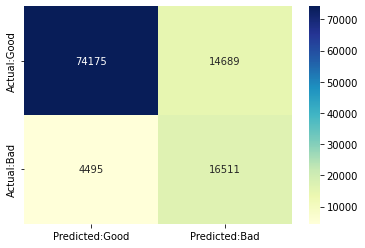

In [85]:
con_mat = pd.DataFrame(confusion_matrix(sgd_cls.predict(X_test), y_test),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(sgd_cls.predict(X_test), y_test))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

Although precision increased, recall for predicting spam (phishing) links did not improve at 79%.